In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from utils import optimize_e, optimize_b
from joblib import Parallel, delayed
import time
import sys

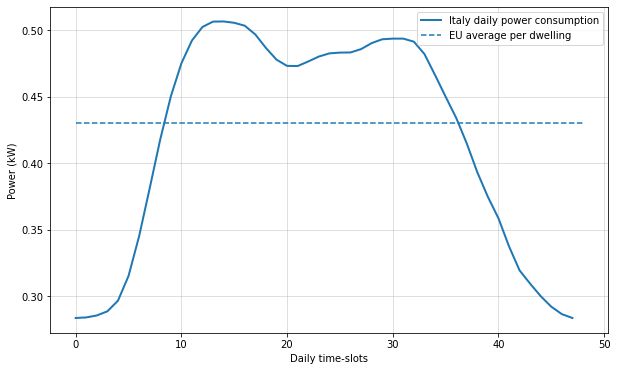

In [2]:
# Import the load profile
load_curve = np.loadtxt('data/load_agg_data.csv', delimiter=',', skiprows=1)[:, 2]
plt.figure(figsize=(10,6))
plt.plot(load_curve, lw=2, label='Italy daily power consumption')
plt.hlines(y=0.43, xmin=0, xmax=48, ls='dashed', label='EU average per dwelling')
plt.xlabel('Daily time-slots')
plt.ylabel('Power (kW)')
plt.grid(alpha=0.5)
plt.legend()

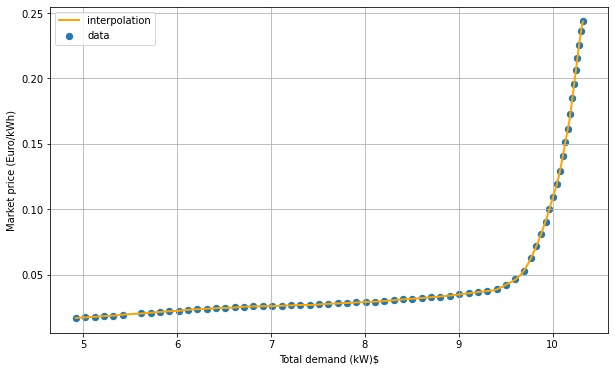

In [3]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 2.6 -1

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data')
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange')
plt.xlabel(r'Total demand (kW)$')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

Italy average consumption per-capita in 1 year: $4750~kWh$

$\Rightarrow 0.55~kW \rightarrow \times 60 \text{ millions} \rightarrow 3.3 \cdot 10^4~ MW$

# Grid simulation

## Consumer's parameters

- EU per-dwelling consumption 3.7 MWh $\rightarrow$ 0.43 kW

In [5]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

## Simulation

In [5]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

In [6]:
# Customer's utility function: for optimizing wrt b_pm
def u_b(b_pm, p, l, c, e):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - b_pm[T:] + l)) + c*e


# Customer's utility function: for optimizing wrt e
def u_e(e, b_pm, p, l, c):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - b_pm[T:] + l)) + c*e

First step

In [7]:
# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))

Text(0.5, 1.0, 'price profile')

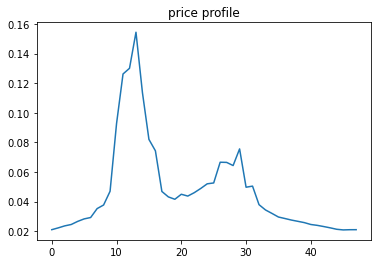

In [8]:
plt.plot(p)
plt.title('price profile')

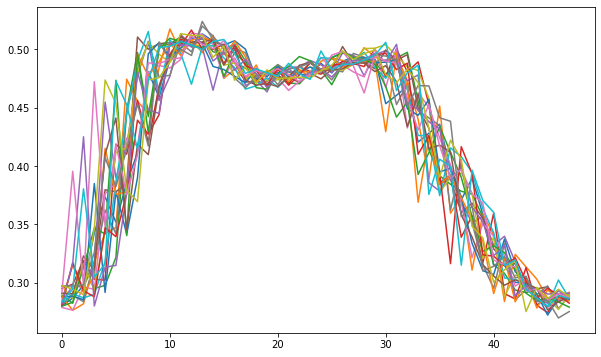

In [9]:
plt.figure(figsize=(10,6))
for i in range(n_nodes):
    plt.plot(l[i,:])

First I optimize $u(b, p, l, c, e)$ wrt $e$

In [10]:
# generate constraint
constr_ev = np.zeros(T)
for i in range(T):
    constr_ev[i] = b_pm[0, i] + e0[0] + np.sum(b_pm[0, :i] - b_pm[0, T : T+i])

constr_e = np.max(constr_ev)

from scipy.optimize import minimize_scalar
e_opt = minimize_scalar(u_e, args=(b_pm[0, :], p, l[0, :], c[0]),
    method='Bounded',
    bounds=(constr_e, 5.))

Update the storage capacity 

In [11]:
e[0] = e[0] + beta_1*(e_opt.x - e[0])

Maximize wrt b

In [12]:
# Generate the constraint matrix

# storage efficiency
mat1 = np.zeros(shape=(1, 2*T), dtype='float')
for j in range(T):
    mat1[0, j] = -alpha
    mat1[0, j+T] = 1

# within charging and discharging capacity
mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

# energy that can be stored or used at a time slot
mat4 = np.zeros(shape=(T, 2*T), dtype='float')
for i in range(1, T):
    mat4[i, :i] = -alpha
    mat4[i, T:T+i] = alpha
for i in range(T):
    mat4[i, T+i] = 1

mat5 = np.zeros(shape=(T, 2*T), dtype='float')
for i in range(1, T):
    mat5[i, :i] = 1
    mat5[i, T:T+i] = -1
for i in range(T):
    mat5[i, i] = 1    

mat_constr = np.vstack([mat1, mat2, mat3, mat4, mat5, mat3])

In [13]:
# generate constraint vector ( leftv <= mat_constr * X <= rightv )

# left
leftv1 = np.zeros(1)          # bilateral
leftv2 = np.zeros(T)          # bilateral
leftv3 = np.zeros(T)          # bilateral
leftv4 = -np.ones(T)*np.inf   # unilateral
leftv5 = -np.ones(T)*np.inf   # unilateral
leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5, leftv3])

# right
rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [alpha * e0[0]] * T, [e[0] - e0[0]] * T, l[0, :]])

In [14]:
from scipy.optimize import Bounds, LinearConstraint
linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
x0 = np.zeros(2 * T)
b_opt = minimize(u_b, x0, args=(p, l[0, :], c[0], e[0]), method='trust-constr',
    constraints=linear_constraint,
    bounds=bounds,
    options={'factorization_method' : 'SVDFactorization', 'verbose' : 0})

Update the storage profile

In [15]:
b_pm[0, :] = b_pm[0, :] + beta_2 * (b_opt.x - b_pm[0, :]) 

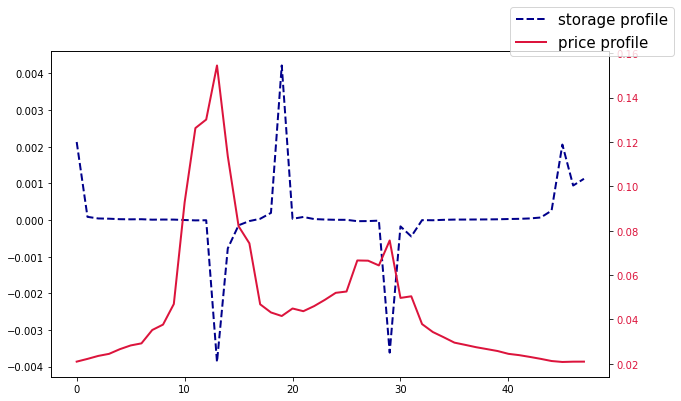

In [16]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(b_pm[0, :T] - b_pm[0, T:], label='storage profile', lw=2, ls='dashed', c='darkblue')
ax2 = ax1.twinx()
ax2.plot(p, label='price profile', lw=2, c='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
fig.legend(fontsize=15)

In [17]:
np.sum(b_pm[0, :T] - b_pm[0, T:])

0.002372748236472424

Now I do it for all players

In [13]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))

In [25]:
profiles = np.ndarray((n_nodes, T))
for n in range(n_nodes):
    # optimize e
    e_opt = optimize_e(n, b_pm, p, l, c, e0)
    # update e
    e[n] = e[n] + beta_1*(e_opt - e[n])
    # optimize b
    b_opt = optimize_b(n, b_sup, b_inf, p, c, alpha, e0, e, l)
    # update b
    b_pm[n, :] = b_pm[n, :] + beta_2 * (b_opt - b_pm[n, :])
    profiles[n, :] = b_pm[n, :T] - b_pm[n, T:]
    print(f'completed node {n+1}/{n_nodes}')

completed node 1/20
completed node 2/20
completed node 3/20
completed node 4/20
completed node 5/20
completed node 6/20
completed node 7/20
completed node 8/20
completed node 9/20
completed node 10/20
completed node 11/20
completed node 12/20
completed node 13/20
completed node 14/20
completed node 15/20
completed node 16/20
completed node 17/20
completed node 18/20
completed node 19/20
completed node 20/20


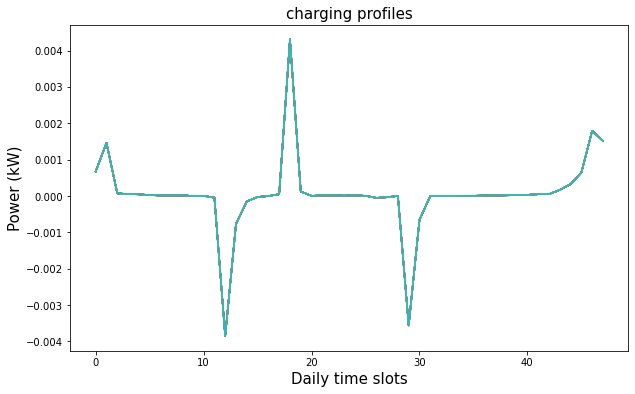

In [20]:
plt.figure(figsize=(10,6))
plt.xlabel('Daily time slots', size=15)
plt.ylabel('Power (kW)', size=15)
plt.title('charging profiles', size=15)
for profile in profiles:
    plt.plot(profile)

### Complete simulation

In [21]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

In [22]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history
e_history = np.array([])                # total storage

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
e_history = np.append(e_history, e.sum())

In [90]:
for d in range(n_days):
    profiles = np.ndarray((n_nodes, T))
    for n in range(n_nodes):
        # optimize e
        e_opt = optimize_e(n, b_pm, p, l, c, e0)
        # update e
        e[n] = e[n] + beta_1*(e_opt - e[n])
        # optimize b
        b_opt = optimize_b(n, b_sup, b_inf, p, c, alpha, e0, e, l)
        # update b
        b_pm[n, :] = b_pm[n, :] + beta_2 * (b_opt - b_pm[n, :])
        # update e0
        e0[n] = e0[n] + b_pm[n, :T].sum() - b_pm[n, T:].sum()
        
        profiles[n, :] = b_pm[n, :T] - b_pm[n, T:]
        print(f'completed node {n+1}/{n_nodes} of day {d+1}/{n_days}', end='\r')
        sys.stdout.flush()
    b_history = np.append(b_history, [np.mean(profiles, axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    e_history = np.append(e_history, e.sum())

/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


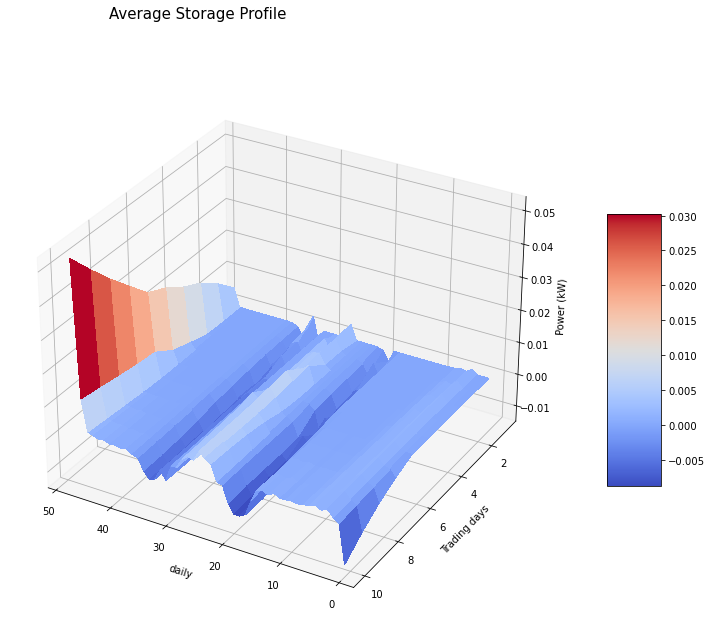

In [92]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Power (kW)', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Average Storage Profile', size=15);

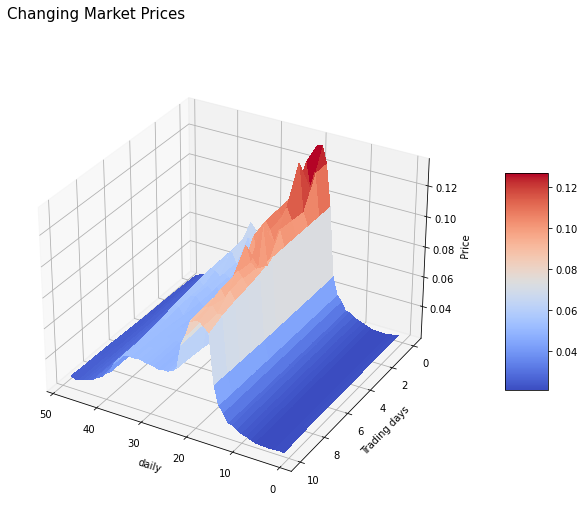

In [93]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Price', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Changing Market Prices', size=15);

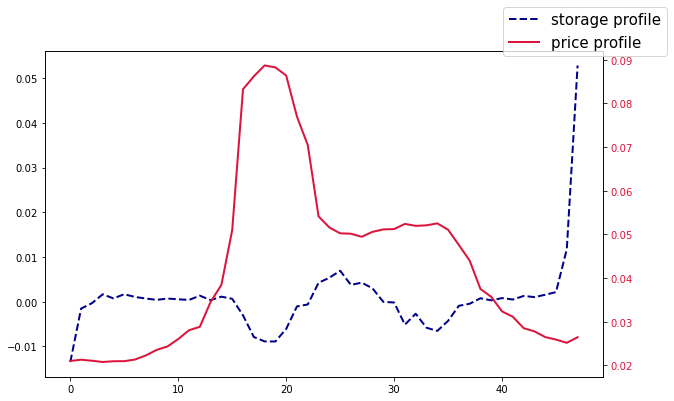

In [94]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(b_history[-1], label='storage profile', lw=2, ls='dashed', c='darkblue')
ax2 = ax1.twinx()
ax2.plot(p_history[-1], label='price profile', lw=2, c='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
fig.legend(fontsize=15)

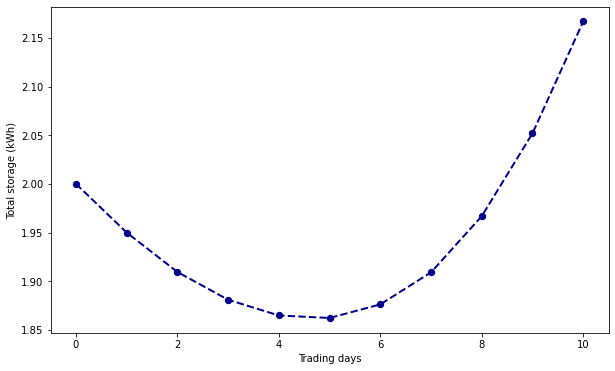

In [95]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(e_history, lw=2, ls='dashed', c='darkblue')
ax1.scatter(np.arange(len(e_history)), e_history, s=40, c='darkblue')
ax1.set_xlabel('Trading days')
ax1.set_ylabel('Total storage (kWh)');

### Parallelize

In [37]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 5                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

In [38]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history
e_history = np.array([])                # total storage

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
e_history = np.append(e_history, e.sum())

In [10]:
for d in range(n_days):
    t_start = time.time()
    profiles = np.ndarray((n_nodes, T))
    b_opt = np.ndarray(shape=(0, 2*T))
    # optimize e
    e_list = np.linspace(0, 4., 30)
    with Parallel(n_jobs=n_nodes) as parallel:
        u_list = parallel(delayed(optimize_e)(n, b_pm, p, l, c, e0) for n in range(n_nodes))
    e_opt = np.array(e_opt)

    # update e
    e = e + beta_1*(e_opt - e)

    # optimize b
    with Parallel(n_jobs=n_nodes) as parallel:
        b_opt_list = parallel(delayed(optimize_b)(b_sup, b_inf, p[n], c[n], alpha, e0[n], e[n], l[n, :]) for n in range(n_nodes))
    for n in range(n_nodes):
        b_opt = np.append(b_opt, [b_opt_list[n]], axis=0)

    # update b
    b_pm = b_pm + beta_2 * (b_opt - b_pm)

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [np.mean(b_pm[:, :T] - b_pm[:, T:], axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    e_history = np.append(e_history, e.sum())
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

completed day 1/5 in 0.12 min
completed day 2/5 in 0.09 min
completed day 3/5 in 4.09 min
completed day 4/5 in 4.09 min
completed day 5/5 in 4.01 min


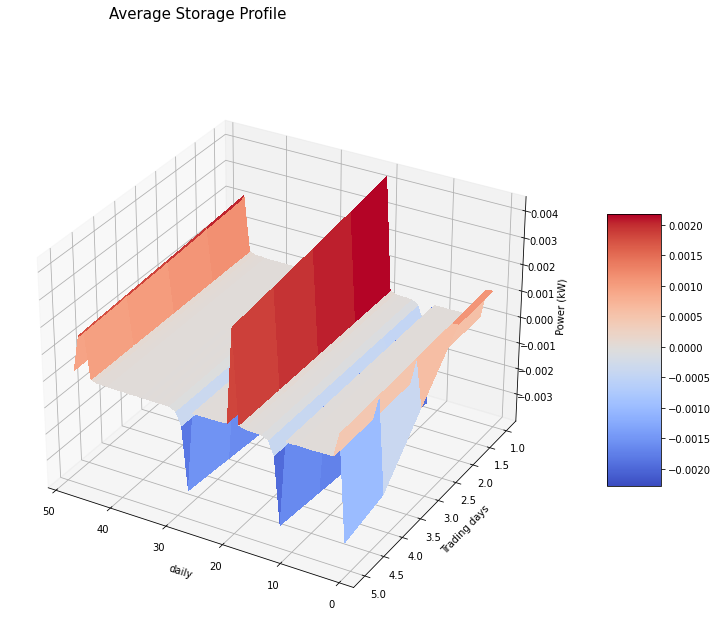

In [11]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Power (kW)', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Average Storage Profile', size=15);

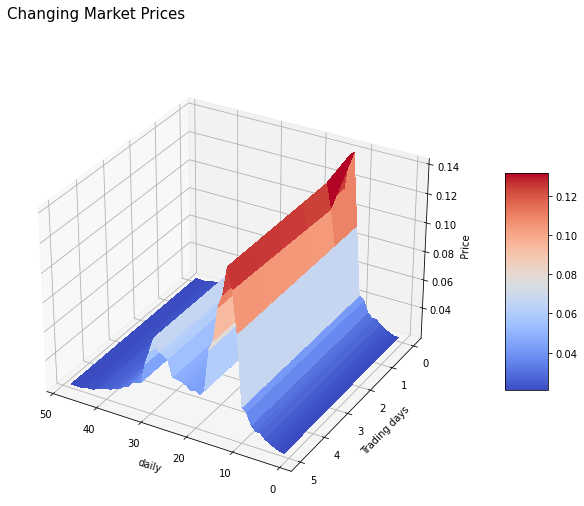

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Price', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Changing Market Prices', size=15);

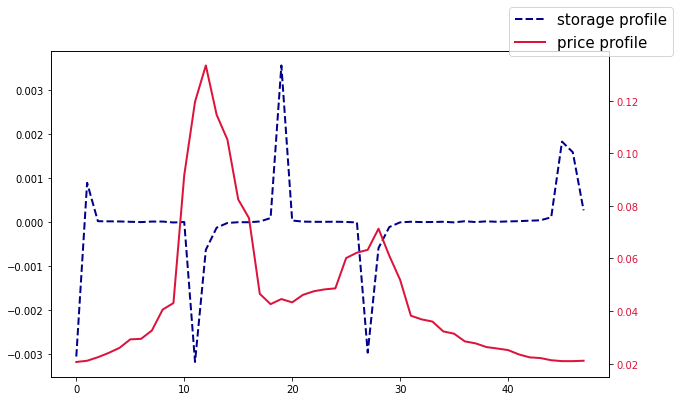

In [13]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(b_history[-1], label='storage profile', lw=2, ls='dashed', c='darkblue')
ax2 = ax1.twinx()
ax2.plot(p_history[-1], label='price profile', lw=2, c='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
fig.legend(fontsize=15)

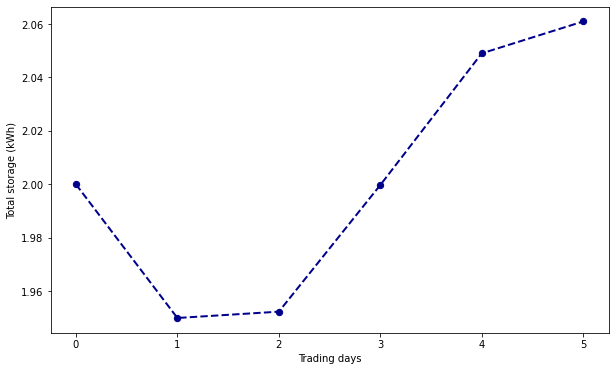

In [14]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(e_history, lw=2, ls='dashed', c='darkblue')
ax1.scatter(np.arange(len(e_history)), e_history, s=40, c='darkblue')
ax1.set_xlabel('Trading days')
ax1.set_ylabel('Total storage (kWh)');

### Energy storage minimization

In [31]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

In [32]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history
e_history = np.array([])                # total storage

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
e_history = np.append(e_history, e.sum())

In [33]:
def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        mat1[0, j] = -alpha
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat4[i, :i] = -alpha
        mat4[i, T:T+i] = alpha
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5, mat3])

def constr_vectors_b(n, b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5, leftv3])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [alpha * e0[n]] * T, [e - e0[n]] * T, l[n, :]])
    return leftv_constr, rightv_constr

In [34]:
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar
def evaluate_e_opt(e, n, p, l, c):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(n, b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    x0 = np.zeros(2 * T)
    b_opt = minimize(u_b, x0, args=(p, l[n, :], c[n], e), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        #options={'factorization_method' : 'SVDFactorization', 'verbose' : 0})
        options={'verbose' : 0})
    return u_b(b_opt.x, p, l[0, :], c[0], e)

In [35]:
e_list = np.linspace(0, 3, 30)
with Parallel(n_jobs=30) as parallel:
    e_vals = parallel(delayed(evaluate_e_opt)(e_val, 0, p, l, c) for e_val in e_list)

Text(0, 0.5, 'cost (Euro)')

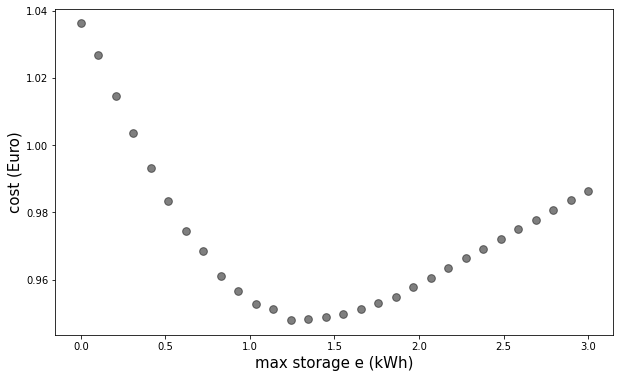

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(e_list, e_vals, s=60, c='black', alpha=0.5)
plt.xlabel('max storage e (kWh)', size=15)
plt.ylabel('cost (Euro)', size=15)

In [22]:
u_b(b_pm[0, :], p, l[0, :], c[0], 3)

1.2020284558648209